# Energy Regression example in the Aleph simulated data

### Data:
The input variables (X) are (where Aleph uses only the first six):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).
* isb:    1 if it is from a b-quark and 0, if it is not.
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, y_pred, which is "closest possible" to the target variable, y. The "closest possible" is left to the user to define in a _Loss Function_. 

* Author: Arnau Morancho Tardà (NBI) and Rasmus Ørsøe (NBI)
* Email:  arnau.morancho@nbi.ku.dk
* Date:   4th of May 2023

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

import time


Possible other packages to consider: cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Read the data

We choose input and target variables:

* 'energy', 'cTheta', and 'phi' are kinematic variables of the jet, and not about the jet type.
   They are good variables for using regression algorithms. In particular, we will predict the energy, which is not cyclic and therefore less considerations need to take into account. We encourage you trying or thinking about how to solve the cyclic problem for 'cTheta' and 'phi'.

Usually one would apply further checks/regularization/standardization of data at this step, but this data has already been "prepared", so we'll move onto seperate the data into input and truth:

In [4]:
#We import the data slightly more convenient here
import pandas as pd 
from pandas import Series, DataFrame 

# Read the data in using Pandas Dataframe and print the variables:
data = pd.DataFrame(np.genfromtxt('../../Week1/AlephBtag_MC_train_Nev5000.csv', names=True))
#data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True))

variables = data.columns
print(variables)

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['energy']
print("  Variables used for training: ", input_variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')
  Variables used for training:  Index(['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel'], dtype='object')


***

# Regression using LightGBM:

This is a solution example using LightGBM (tree based).

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import early_stopping
from scipy.stats import gaussian_kde

In [6]:
X_train, X_test, y_train, y_test = train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

In [7]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_test,  y_test, reference=lgb_train)
params = {
    'boosting_type': 'gbdt', # Traditional Gradient Boosting tree, we are combining many 'weak' learners here!
    'objective': 'regression',   # The outcome is binary, b-quark or not
    'num_leaves': 10,         # Set a maximum tree leaves to avoid overfitting
    'learning_rate': 0.03,
    'verbose':-1,            # Suppress some output
}

# Train the model:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                callbacks=[early_stopping(40)])     # Stops if no improvement is seen in N rounds.

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[535]	valid_0's l2: 27.3787


In [8]:
# Make predictions:
y_pred_lgbm = gbm.predict(X_test)  # Scores are floats in the range ]0,1[.
# accuracy check
mse = mean_squared_error(y_test, y_pred_lgbm)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 27.38
RMSE: 5.23


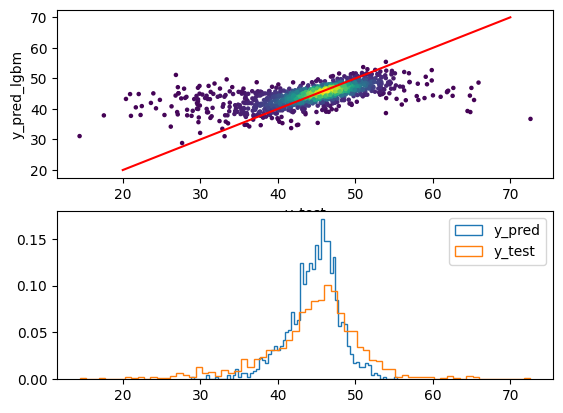

In [9]:
x = np.linspace(20,70,100)
y = x

# Calculate the point density
xy = np.vstack([y_test,y_pred_lgbm])
z = gaussian_kde(xy)(xy)

fig, axs = plt.subplots(2)
axs[0].scatter(y_test,y_pred_lgbm, c=z, s=5)
axs[0].plot(x, y, '-r')
axs[0].set_xlabel('y_test')
axs[0].set_ylabel('y_pred_lgbm')
axs[1].hist(y_pred_lgbm, alpha=1 ,histtype='step', density=True, bins=70, label='y_pred')
axs[1].hist(y_test,alpha=1 ,histtype='step', density=True, bins=70, label='y_test')
axs[1].legend()

## Optimization LightGBM

### Random Search

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, poisson,uniform
import random

In [11]:
gbm = lgb.LGBMRegressor()
# specify parameters and distributions to sample from
parameters_RandomSearch = {'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base= 10, num=1000)),#random.uniform(1e-6, 1e-3),
                           'num_leaves': poisson(50),
                           'max_depth': randint(1, 50), 
                           'n_estimators' : poisson(500), 
                           #'learning_rate': uniform(),
                          }

In [12]:
# run randomized search
n_iter_search = 20
RandomSearch = RandomizedSearchCV(gbm, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  #scoring = 'neg_mean_absolute_error',
                                  cv=5, 
                                  return_train_score=True,
                                  random_state=42,
                                 )

In [13]:
# fit the random search instance
RandomSearch.fit(X_train, y_train);

In [14]:
RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.3f}")

Random Search: 	Best parameters:  {'learning_rate': 0.0080015515686935, 'max_depth': 29, 'n_estimators': 477, 'num_leaves': 52} , Best scores: 0.319


In [15]:
RandomSearch_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.088535,0.243622,0.007193,0.000614,0.008002,29,477,52,"{'learning_rate': 0.0080015515686935, 'max_dep...",0.327811,...,0.318619,0.025473,1,0.598594,0.617153,0.625371,0.617848,0.617428,0.615279,0.008888
1,1.949679,0.030000,0.005967,0.000421,0.013409,11,497,41,"{'learning_rate': 0.013409063047265076, 'max_d...",0.319200,...,0.314340,0.025799,3,0.618859,0.647671,0.652751,0.646276,0.649067,0.642925,0.012224
2,0.263148,0.005972,0.002441,0.000118,0.020682,2,508,50,"{'learning_rate': 0.020681718420316363, 'max_d...",0.265225,...,0.257827,0.018190,13,0.306856,0.336136,0.330224,0.326599,0.333532,0.326669,0.010411
3,2.362994,0.042513,0.007861,0.000671,0.04466,16,481,52,"{'learning_rate': 0.04466022999290484, 'max_de...",0.289047,...,0.276242,0.017636,8,0.882498,0.897703,0.894685,0.890180,0.890406,0.891094,0.005134
4,0.420286,0.009996,0.002453,0.000580,0.015327,3,528,49,"{'learning_rate': 0.015326976475282632, 'max_d...",0.271966,...,0.274578,0.024475,9,0.356188,0.380704,0.389837,0.384978,0.378334,0.378008,0.011593
5,2.022810,0.050339,0.007752,0.000580,0.079464,14,522,39,"{'learning_rate': 0.07946414328114888, 'max_de...",0.254264,...,0.240184,0.020386,16,0.934543,0.942230,0.940206,0.936288,0.938450,0.938343,0.002730
6,1.339863,0.022332,0.004770,0.000893,0.027021,7,507,42,"{'learning_rate': 0.027021082103529572, 'max_d...",0.314552,...,0.302658,0.025873,5,0.674539,0.688595,0.683044,0.677779,0.699464,0.684684,0.008798
7,2.405670,0.028401,0.008952,0.001191,0.066389,40,517,43,"{'learning_rate': 0.06638854146777148, 'max_de...",0.261881,...,0.248067,0.015040,15,0.936318,0.942992,0.942493,0.940398,0.941043,0.940649,0.002361
8,3.122027,0.053699,0.009144,0.001321,0.044867,18,533,62,"{'learning_rate': 0.04486657907291759, 'max_de...",0.279093,...,0.267206,0.020645,11,0.924195,0.935546,0.930316,0.930252,0.931745,0.930411,0.003656
9,2.816146,0.047809,0.008933,0.001005,0.142044,40,526,51,"{'learning_rate': 0.14204418450916512, 'max_de...",0.217265,...,0.200188,0.013073,19,0.995452,0.996062,0.995820,0.995427,0.995636,0.995679,0.000238


In [16]:
clf_RandomSearch = RandomSearch.best_estimator_


# Make predictions:
y_pred_lgbm_rand_opt = clf_RandomSearch.predict(X_test)  # Scores are floats in the range ]0,1[.
# accuracy check
mse_lgb_rand_opt = mean_squared_error(y_test, y_pred_lgbm_rand_opt)
rmse_lgb_rand_opt = mse_lgb_rand_opt**(0.5)

print(f'RMSE LightGBM no optimization: {rmse:.4f}')
print(f'RMSE LightGBM Random Search: {rmse_lgb_rand_opt:.4f}')

RMSE LightGBM no optimization: 5.2325
RMSE LightGBM Random Search: 5.1717


***

# Regression using TensorFlow:

This is a solution example using TensorFlow (NN based).


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import QuantileTransformer
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import torch
from keras.optimizers import Adam  

In [18]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')  #Use GPU

Something important for neural networks is that all the input data should be normalized or standarized. As mentioned before all the input data is already prepared but the output (energy) is not. So as an example we show one way of using one of this transorfations (QuantileTransformer). After we have predict our target we can do the inverse transformation to get the expected scale. 


In [19]:
qt = QuantileTransformer(n_quantiles=10, random_state=0)
y_norm = qt.fit_transform(truth_data.array.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(input_data, y_norm, test_size=0.25, random_state=42)

In [20]:
# set up the network hyperparameters
n_inputs = 6
n_hidden1 = 10
n_hidden2 = 10
n_hidden3 = 10
n_outputs = 1
batch_norm_momentum = 0.9
#learning_rate = 0.001 # adam optimizer adapts the value of the learning rate
init = tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in')
#centropy = tf.keras.losses.BinaryCrossentropy() #good for categorical data SparseCategoricalCrossentropy(from_logits=True)

# network structure
def base_model():
    nn_reg = tf.keras.models.Sequential([
      Dense(units=n_inputs, input_dim=n_inputs, kernel_initializer='normal', activation='relu'),
      Dense(n_hidden1, activation='relu', kernel_initializer='normal'),
      BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
      Dense(n_hidden2, activation='relu', kernel_initializer='normal'),
      BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
      Dense(n_hidden3, activation='relu', kernel_initializer='normal'),
      BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
      Dense(n_outputs, kernel_initializer='normal')
    ])
    
    nn_reg.compile(loss='mean_squared_error', optimizer='adam')#, metrics=['accuracy'])
#log_cosh
    return nn_reg

n_epochs = 30
batch_size = 300

clf = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size ,verbose=1)    
history = clf.fit(x=(X_train),y=(y_train), validation_data=(np.array(X_test), np.array(y_test)))

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/3500438816.py:32: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size ,verbose=1)


Metal device set to: Apple M2 Pro
Epoch 1/30


2023-05-09 18:09:32.544768: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 1s 51ms/step - loss: 0.3133 - val_loss: 0.3122
Epoch 2/30
13/13 [==============================] - 0s 16ms/step - loss: 0.2918 - val_loss: 0.2935
Epoch 3/30
13/13 [==============================] - 0s 15ms/step - loss: 0.2706 - val_loss: 0.2728
Epoch 4/30
13/13 [==============================] - 0s 16ms/step - loss: 0.2456 - val_loss: 0.2462
Epoch 5/30
13/13 [==============================] - 0s 16ms/step - loss: 0.2180 - val_loss: 0.2059
Epoch 6/30
13/13 [==============================] - 0s 16ms/step - loss: 0.1887 - val_loss: 0.1891
Epoch 7/30
13/13 [==============================] - 0s 15ms/step - loss: 0.1596 - val_loss: 0.1848
Epoch 8/30
13/13 [==============================] - 0s 15ms/step - loss: 0.1323 - val_loss: 0.1422
Epoch 9/30
13/13 [==============================] - 0s 15ms/step - loss: 0.1097 - val_loss: 0.1021
Epoch 10/30
13/13 [==============================] - 0s 15ms/step - loss: 0.0907 - val_loss: 0.1048
Epoch 11/30
13/13 [=

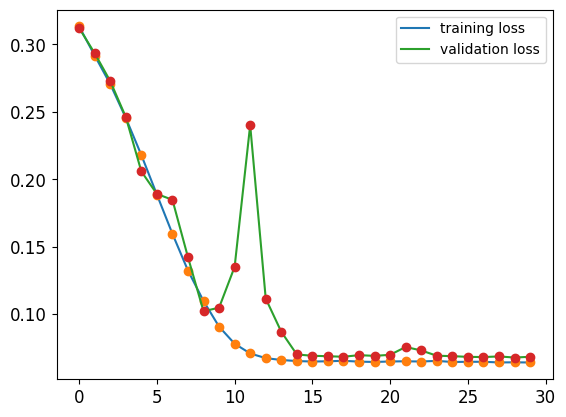

In [21]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

In [22]:
y_pred_tf_norm = clf.predict(X_test)

#Renormalize
y_pred_tf = qt.inverse_transform(y_pred_tf_norm.reshape(-1, 1))
y_test_tf = qt.inverse_transform(y_test.reshape(-1, 1))

5/5 [==============================] - 0s 10ms/step


In [23]:
# accuracy check
mse_tf = mean_squared_error(y_test_tf, y_pred_tf)
rmse_tf = mse_tf**(0.5) 

print(f'RMSE LightGBM no optimization: {rmse:.4f}')
print(f'RMSE LightGBM Random Search: {rmse_lgb_rand_opt:.4f}')
print(f'RMSE TensorFlow no optimization: {rmse_tf:.4f}')

RMSE LightGBM no optimization: 5.2325
RMSE LightGBM Random Search: 5.1717
RMSE TensorFlow no optimization: 6.1513


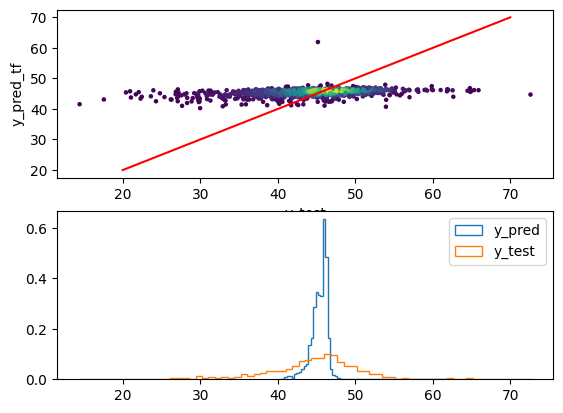

In [24]:
x = np.linspace(20,70,100)
y = x

# Calculate the point density
xy = np.vstack([y_test_tf.reshape(-1),y_pred_tf.reshape(-1)])
z = gaussian_kde(xy)(xy)


fig, axs = plt.subplots(2)
axs[0].scatter(y_test_tf,y_pred_tf, c=z, s=5)
axs[0].plot(x, y, '-r')
axs[0].set_xlabel('y_test')
axs[0].set_ylabel('y_pred_tf')
axs[1].hist(y_pred_tf, alpha=1 ,histtype='step', density=True, bins=70, label='y_pred')
axs[1].hist(y_test_tf,alpha=1 ,histtype='step', density=True, bins=70, label='y_test')
axs[1].legend()


## Optimize TensorFlow using Random search

In [25]:
from sklearn.model_selection import RandomizedSearchCV

In [26]:
# specify parameters and distributions to sample from
parameters_RandomSearch = {"epochs": randint(10, 60), 
                           "batch_size": randint(100,2000),
                           #"n_hidden1": (10,500),
                           #"n_hidden2": (10,500),
                           #"n_hidden3": (10,500),
                          }

In [27]:
# run randomized search
n_iter_search = 9
RandomSearch_tf = RandomizedSearchCV(clf, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5, 
                                  return_train_score=True,
                                  random_state=42,
                                 )

In [28]:
# fit the random search instance
RandomSearch_tf.fit(X_train, y_train);

Epoch 1/38
3/3 [==============================] - 1s 110ms/step - loss: 0.3192
Epoch 2/38
3/3 [==============================] - 0s 27ms/step - loss: 0.3129
Epoch 3/38
3/3 [==============================] - 0s 14ms/step - loss: 0.3072
Epoch 4/38
3/3 [==============================] - 0s 23ms/step - loss: 0.3019
Epoch 5/38
3/3 [==============================] - 0s 19ms/step - loss: 0.2963
Epoch 6/38
3/3 [==============================] - 0s 21ms/step - loss: 0.2907
Epoch 7/38
3/3 [==============================] - 0s 14ms/step - loss: 0.2848
Epoch 8/38
3/3 [==============================] - 0s 13ms/step - loss: 0.2788
Epoch 9/38
3/3 [==============================] - 0s 13ms/step - loss: 0.2729
Epoch 10/38
3/3 [==============================] - 0s 12ms/step - loss: 0.2668
Epoch 11/38
3/3 [==============================] - 0s 13ms/step - loss: 0.2605
Epoch 12/38
3/3 [==============================] - 0s 21ms/step - loss: 0.2539
Epoch 13/38
3/3 [==============================] - 0s 13ms/s

3/3 [==============================] - 0s 12ms/step - loss: 0.1763
Epoch 26/38
3/3 [==============================] - 0s 11ms/step - loss: 0.1694
Epoch 27/38
3/3 [==============================] - 0s 11ms/step - loss: 0.1625
Epoch 28/38
3/3 [==============================] - 0s 12ms/step - loss: 0.1558
Epoch 29/38
3/3 [==============================] - 0s 11ms/step - loss: 0.1491
Epoch 30/38
3/3 [==============================] - 0s 12ms/step - loss: 0.1425
Epoch 31/38
3/3 [==============================] - 0s 11ms/step - loss: 0.1362
Epoch 32/38
3/3 [==============================] - 0s 11ms/step - loss: 0.1300
Epoch 33/38
3/3 [==============================] - 0s 11ms/step - loss: 0.1241
Epoch 34/38
3/3 [==============================] - 0s 11ms/step - loss: 0.1183
Epoch 35/38
3/3 [==============================] - 0s 11ms/step - loss: 0.1130
Epoch 36/38
3/3 [==============================] - 0s 11ms/step - loss: 0.1079
Epoch 37/38
3/3 [==============================] - 0s 11ms/step 

3/3 [==============================] - 0s 12ms/step - loss: 0.2710
Epoch 11/52
3/3 [==============================] - 0s 13ms/step - loss: 0.2651
Epoch 12/52
3/3 [==============================] - 0s 12ms/step - loss: 0.2593
Epoch 13/52
3/3 [==============================] - 0s 12ms/step - loss: 0.2532
Epoch 14/52
3/3 [==============================] - 0s 12ms/step - loss: 0.2475
Epoch 15/52
3/3 [==============================] - 0s 20ms/step - loss: 0.2410
Epoch 16/52
3/3 [==============================] - 0s 12ms/step - loss: 0.2349
Epoch 17/52
3/3 [==============================] - 0s 11ms/step - loss: 0.2281
Epoch 18/52
3/3 [==============================] - 0s 11ms/step - loss: 0.2220
Epoch 19/52
3/3 [==============================] - 0s 12ms/step - loss: 0.2148
Epoch 20/52
3/3 [==============================] - 0s 11ms/step - loss: 0.2081
Epoch 21/52
3/3 [==============================] - 0s 12ms/step - loss: 0.2010
Epoch 22/52
3/3 [==============================] - 0s 11ms/step 

3/3 [==============================] - 0s 22ms/step - loss: 0.3001
Epoch 7/52
3/3 [==============================] - 0s 28ms/step - loss: 0.2952
Epoch 8/52
3/3 [==============================] - 0s 13ms/step - loss: 0.2900
Epoch 9/52
3/3 [==============================] - 0s 14ms/step - loss: 0.2846
Epoch 10/52
3/3 [==============================] - 0s 47ms/step - loss: 0.2792
Epoch 11/52
3/3 [==============================] - 0s 13ms/step - loss: 0.2738
Epoch 12/52
3/3 [==============================] - 0s 14ms/step - loss: 0.2682
Epoch 13/52
3/3 [==============================] - 0s 23ms/step - loss: 0.2625
Epoch 14/52
3/3 [==============================] - 0s 16ms/step - loss: 0.2568
Epoch 15/52
3/3 [==============================] - 0s 13ms/step - loss: 0.2510
Epoch 16/52
3/3 [==============================] - 0s 13ms/step - loss: 0.2447
Epoch 17/52
3/3 [==============================] - 0s 47ms/step - loss: 0.2383
Epoch 18/52
3/3 [==============================] - 0s 14ms/step - l

3/3 [==============================] - 0s 58ms/step - loss: 0.3177
Epoch 3/52
3/3 [==============================] - 0s 31ms/step - loss: 0.3127
Epoch 4/52
3/3 [==============================] - 0s 21ms/step - loss: 0.3076
Epoch 5/52
3/3 [==============================] - 0s 52ms/step - loss: 0.3023
Epoch 6/52
3/3 [==============================] - 0s 14ms/step - loss: 0.2966
Epoch 7/52
3/3 [==============================] - 0s 13ms/step - loss: 0.2910
Epoch 8/52
3/3 [==============================] - 0s 12ms/step - loss: 0.2849
Epoch 9/52
3/3 [==============================] - 0s 36ms/step - loss: 0.2788
Epoch 10/52
3/3 [==============================] - 0s 13ms/step - loss: 0.2724
Epoch 11/52
3/3 [==============================] - 0s 21ms/step - loss: 0.2660
Epoch 12/52
3/3 [==============================] - 0s 12ms/step - loss: 0.2598
Epoch 13/52
3/3 [==============================] - 0s 28ms/step - loss: 0.2532
Epoch 14/52
3/3 [==============================] - 0s 13ms/step - loss:

3/3 [==============================] - 0s 11ms/step - loss: 0.2081
Epoch 21/30
3/3 [==============================] - 0s 12ms/step - loss: 0.2013
Epoch 22/30
3/3 [==============================] - 0s 12ms/step - loss: 0.1944
Epoch 23/30
3/3 [==============================] - 0s 12ms/step - loss: 0.1875
Epoch 24/30
3/3 [==============================] - 0s 12ms/step - loss: 0.1803
Epoch 25/30
3/3 [==============================] - 0s 12ms/step - loss: 0.1733
Epoch 26/30
3/3 [==============================] - 0s 12ms/step - loss: 0.1664
Epoch 27/30
3/3 [==============================] - 0s 12ms/step - loss: 0.1595
Epoch 28/30
3/3 [==============================] - 0s 11ms/step - loss: 0.1530
Epoch 29/30
3/3 [==============================] - 0s 12ms/step - loss: 0.1465
Epoch 30/30
3/3 [==============================] - 0s 40ms/step - loss: 0.1314
Epoch 1/30
3/3 [==============================] - 1s 192ms/step - loss: 0.3239
Epoch 2/30
3/3 [==============================] - 0s 94ms/step -

3/3 [==============================] - 0s 11ms/step - loss: 0.1507
Epoch 30/30
3/3 [==============================] - 0s 45ms/step - loss: 0.1281
Epoch 1/28
2/2 [==============================] - 2s 409ms/step - loss: 0.3216
Epoch 2/28
2/2 [==============================] - 0s 109ms/step - loss: 0.3165
Epoch 3/28
2/2 [==============================] - 0s 18ms/step - loss: 0.3134
Epoch 4/28
2/2 [==============================] - 0s 44ms/step - loss: 0.3099
Epoch 5/28
2/2 [==============================] - 0s 17ms/step - loss: 0.3061
Epoch 6/28
2/2 [==============================] - 0s 16ms/step - loss: 0.3025
Epoch 7/28
2/2 [==============================] - 0s 13ms/step - loss: 0.2991
Epoch 8/28
2/2 [==============================] - 0s 121ms/step - loss: 0.2956
Epoch 9/28
2/2 [==============================] - 0s 14ms/step - loss: 0.2921
Epoch 10/28
2/2 [==============================] - 0s 91ms/step - loss: 0.2887
Epoch 11/28
2/2 [==============================] - 0s 16ms/step - loss

2/2 [==============================] - 0s 40ms/step - loss: 0.2840
Epoch 13/28
2/2 [==============================] - 0s 13ms/step - loss: 0.2801
Epoch 14/28
2/2 [==============================] - 0s 14ms/step - loss: 0.2762
Epoch 15/28
2/2 [==============================] - 0s 14ms/step - loss: 0.2722
Epoch 16/28
2/2 [==============================] - 0s 13ms/step - loss: 0.2681
Epoch 17/28
2/2 [==============================] - 0s 13ms/step - loss: 0.2640
Epoch 18/28
2/2 [==============================] - 0s 13ms/step - loss: 0.2597
Epoch 19/28
2/2 [==============================] - 0s 14ms/step - loss: 0.2555
Epoch 20/28
2/2 [==============================] - 0s 14ms/step - loss: 0.2510
Epoch 21/28
2/2 [==============================] - 0s 16ms/step - loss: 0.2467
Epoch 22/28
2/2 [==============================] - 0s 19ms/step - loss: 0.2422
Epoch 23/28
2/2 [==============================] - 0s 109ms/step - loss: 0.2375
Epoch 24/28
2/2 [==============================] - 0s 16ms/step

3/3 [==============================] - 0s 17ms/step - loss: 0.2365
Epoch 18/20
3/3 [==============================] - 0s 13ms/step - loss: 0.2298
Epoch 19/20
3/3 [==============================] - 0s 11ms/step - loss: 0.2231
Epoch 20/20
3/3 [==============================] - 0s 52ms/step - loss: 0.2172
Epoch 1/20
3/3 [==============================] - 2s 299ms/step - loss: 0.3237
Epoch 2/20
3/3 [==============================] - 0s 140ms/step - loss: 0.3183
Epoch 3/20
3/3 [==============================] - 0s 92ms/step - loss: 0.3141
Epoch 4/20
3/3 [==============================] - 0s 16ms/step - loss: 0.3096
Epoch 5/20
3/3 [==============================] - 0s 15ms/step - loss: 0.3047
Epoch 6/20
3/3 [==============================] - 0s 14ms/step - loss: 0.2995
Epoch 7/20
3/3 [==============================] - 0s 13ms/step - loss: 0.2938
Epoch 8/20
3/3 [==============================] - 0s 115ms/step - loss: 0.2886
Epoch 9/20
3/3 [==============================] - 0s 59ms/step - loss

2/2 [==============================] - 0s 130ms/step - loss: 0.1926
Epoch 1/33
2/2 [==============================] - 2s 584ms/step - loss: 0.3203
Epoch 2/33
2/2 [==============================] - 0s 95ms/step - loss: 0.3170
Epoch 3/33
2/2 [==============================] - 0s 202ms/step - loss: 0.3135
Epoch 4/33
2/2 [==============================] - 0s 146ms/step - loss: 0.3103
Epoch 5/33
2/2 [==============================] - 0s 24ms/step - loss: 0.3073
Epoch 6/33
2/2 [==============================] - 0s 80ms/step - loss: 0.3041
Epoch 7/33
2/2 [==============================] - 0s 87ms/step - loss: 0.3008
Epoch 8/33
2/2 [==============================] - 0s 16ms/step - loss: 0.2974
Epoch 9/33
2/2 [==============================] - 0s 117ms/step - loss: 0.2939
Epoch 10/33
2/2 [==============================] - 0s 18ms/step - loss: 0.2905
Epoch 11/33
2/2 [==============================] - 0s 16ms/step - loss: 0.2868
Epoch 12/33
2/2 [==============================] - 0s 17ms/step - lo

2/2 [==============================] - 0s 133ms/step - loss: 0.1619
Epoch 1/33
2/2 [==============================] - 2s 657ms/step - loss: 0.3231
Epoch 2/33
2/2 [==============================] - 0s 121ms/step - loss: 0.3182
Epoch 3/33
2/2 [==============================] - 0s 118ms/step - loss: 0.3147
Epoch 4/33
2/2 [==============================] - 0s 127ms/step - loss: 0.3114
Epoch 5/33
2/2 [==============================] - 0s 92ms/step - loss: 0.3079
Epoch 6/33
2/2 [==============================] - 0s 18ms/step - loss: 0.3046
Epoch 7/33
2/2 [==============================] - 0s 165ms/step - loss: 0.3011
Epoch 8/33
2/2 [==============================] - 0s 36ms/step - loss: 0.2977
Epoch 9/33
2/2 [==============================] - 0s 19ms/step - loss: 0.2941
Epoch 10/33
2/2 [==============================] - 0s 15ms/step - loss: 0.2904
Epoch 11/33
2/2 [==============================] - 0s 15ms/step - loss: 0.2866
Epoch 12/33
2/2 [==============================] - 0s 14ms/step - l

Epoch 21/45
3/3 [==============================] - 0s 12ms/step - loss: 0.2172
Epoch 22/45
3/3 [==============================] - 0s 11ms/step - loss: 0.2102
Epoch 23/45
3/3 [==============================] - 0s 12ms/step - loss: 0.2040
Epoch 24/45
3/3 [==============================] - 0s 11ms/step - loss: 0.1975
Epoch 25/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1910
Epoch 26/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1844
Epoch 27/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1780
Epoch 28/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1720
Epoch 29/45
3/3 [==============================] - 0s 13ms/step - loss: 0.1657
Epoch 30/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1592
Epoch 31/45
3/3 [==============================] - 0s 11ms/step - loss: 0.1523
Epoch 32/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1460
Epoch 33/45
3/3 [==============================] - 0

3/3 [==============================] - 0s 31ms/step - loss: 0.1661
Epoch 32/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1594
Epoch 33/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1531
Epoch 34/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1515
Epoch 35/45
3/3 [==============================] - 0s 11ms/step - loss: 0.1451
Epoch 36/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1362
Epoch 37/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1306
Epoch 38/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1259
Epoch 39/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1208
Epoch 40/45
3/3 [==============================] - 0s 13ms/step - loss: 0.1147
Epoch 41/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1086
Epoch 42/45
3/3 [==============================] - 0s 12ms/step - loss: 0.1046
Epoch 43/45
3/3 [==============================] - 0s 12ms/step 

Epoch 7/33
4/4 [==============================] - 0s 45ms/step - loss: 0.2802
Epoch 8/33
4/4 [==============================] - 0s 13ms/step - loss: 0.2723
Epoch 9/33
4/4 [==============================] - 0s 12ms/step - loss: 0.2651
Epoch 10/33
4/4 [==============================] - 0s 13ms/step - loss: 0.2570
Epoch 11/33
4/4 [==============================] - 0s 13ms/step - loss: 0.2485
Epoch 12/33
4/4 [==============================] - 0s 12ms/step - loss: 0.2402
Epoch 13/33
4/4 [==============================] - 0s 11ms/step - loss: 0.2314
Epoch 14/33
4/4 [==============================] - 0s 12ms/step - loss: 0.2229
Epoch 15/33
4/4 [==============================] - 0s 12ms/step - loss: 0.2140
Epoch 16/33
4/4 [==============================] - 0s 43ms/step - loss: 0.2048
Epoch 17/33
4/4 [==============================] - 0s 12ms/step - loss: 0.1955
Epoch 18/33
4/4 [==============================] - 0s 12ms/step - loss: 0.1862
Epoch 19/33
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 53ms/step - loss: 0.2882
Epoch 7/33
4/4 [==============================] - 0s 18ms/step - loss: 0.2805
Epoch 8/33
4/4 [==============================] - 0s 12ms/step - loss: 0.2734
Epoch 9/33
4/4 [==============================] - 0s 11ms/step - loss: 0.2657
Epoch 10/33
4/4 [==============================] - 0s 11ms/step - loss: 0.2582
Epoch 11/33
4/4 [==============================] - 0s 13ms/step - loss: 0.2501
Epoch 12/33
4/4 [==============================] - 0s 11ms/step - loss: 0.2423
Epoch 13/33
4/4 [==============================] - 0s 13ms/step - loss: 0.2338
Epoch 14/33
4/4 [==============================] - 0s 12ms/step - loss: 0.2251
Epoch 15/33
4/4 [==============================] - 0s 12ms/step - loss: 0.2161
Epoch 16/33
4/4 [==============================] - 0s 12ms/step - loss: 0.2071
Epoch 17/33
4/4 [==============================] - 0s 12ms/step - loss: 0.1980
Epoch 18/33
4/4 [==============================] - 0s 13ms/step - l

14/14 [==============================] - 0s 10ms/step - loss: 0.1217
Epoch 9/31
14/14 [==============================] - 0s 10ms/step - loss: 0.0997
Epoch 10/31
14/14 [==============================] - 0s 10ms/step - loss: 0.0832
Epoch 11/31
14/14 [==============================] - 0s 10ms/step - loss: 0.0730
Epoch 12/31
14/14 [==============================] - 0s 13ms/step - loss: 0.0685
Epoch 13/31
14/14 [==============================] - 0s 10ms/step - loss: 0.0664
Epoch 14/31
14/14 [==============================] - 0s 10ms/step - loss: 0.0653
Epoch 15/31
14/14 [==============================] - 0s 15ms/step - loss: 0.0657
Epoch 16/31
14/14 [==============================] - 0s 10ms/step - loss: 0.0658
Epoch 17/31
14/14 [==============================] - 0s 10ms/step - loss: 0.0656
Epoch 18/31
14/14 [==============================] - 0s 10ms/step - loss: 0.0651
Epoch 19/31
14/14 [==============================] - 0s 10ms/step - loss: 0.0652
Epoch 20/31
14/14 [======================

17/17 [==============================] - 0s 17ms/step - loss: 0.0657
Epoch 12/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0654
Epoch 13/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0651
Epoch 14/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0650
Epoch 15/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0649
Epoch 16/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0648
Epoch 17/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0651
Epoch 18/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0646
Epoch 19/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0645
Epoch 20/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0647
Epoch 21/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0645
Epoch 22/31
17/17 [==============================] - 0s 10ms/step - loss: 0.0646
Epoch 23/31
17/17 [=====================

In [29]:
RandomSearch_results_tf = pd.DataFrame(RandomSearch_tf.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch_tf.best_params_, f", Best scores: {RandomSearch_tf.best_score_:.3f}")

Random Search: 	Best parameters:  {'batch_size': 230, 'epochs': 31} , Best scores: -0.066


In [30]:
tf_RandomSearch = RandomSearch_tf.best_estimator_
# Make predictions:
y_pred_tf_rand_opt_norm = tf_RandomSearch.predict(X_test)  

#Renormalize
y_pred_tf_rand_opt = qt.inverse_transform(y_pred_tf_rand_opt_norm.reshape(-1, 1))

# accuracy check
mse_tf_rand_opt = mean_squared_error(y_test_tf, y_pred_tf_rand_opt)
rmse_tf_rand_opt = mse_tf_rand_opt**(0.5)

print(f'RMSE LightGBM no optimization: {rmse:.4f}')
print(f'RMSE LightGBM Random Search: {rmse_lgb_rand_opt:.4f}')
print(f'RMSE TensorFlow no optimization: {rmse_tf:.4f}')
print(f'RMSE TensorFlow Random Search: {rmse_tf_rand_opt:.4f}')

6/6 [==============================] - 3s 68ms/step
RMSE LightGBM no optimization: 5.2325
RMSE LightGBM Random Search: 5.1717
RMSE TensorFlow no optimization: 6.1513
RMSE TensorFlow Random Search: 6.1330


## Optimize TensorFlow using Bayesian Optimization

In [31]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
#from ExternalFunctions import optimize_nn,mean_rel_err_rate

def mean_rel_err_rate(truth,pred):
    return ( np.abs(pred-truth)/truth ).mean()
def TensorFlow_CrossValidation(n_hidden1,n_hidden2,n_hidden3,n_epochs,batch_size,data,targets,cv=5,metric='mean_absolute_error'):
    """
       Fits a TensorFlow with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    own_scorer = make_scorer(mean_rel_err_rate, greater_is_better=False)
    estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)  
    cval = cross_val_score(estimator,data,targets,scoring=own_scorer,cv=cv)
   
    return -cval.mean()

In [32]:
def optimize_TensorFlow(data, targets, pars, n_iter,metric='mean_absolute_error',cv=5):
    """Apply Bayesian Optimization to TensorFlow parameters."""
    
    def crossval_wrapper(n_hidden1,n_hidden2,n_hidden3,n_epochs,batch_size):
        """Wrapper of TensorFlow cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return TensorFlow_CrossValidation(n_hidden1=int(n_hidden1),n_hidden2=int(n_hidden2),n_hidden3=int(n_hidden3),
                                  n_epochs=int(n_epochs),
                                  batch_size=int(batch_size),
                                  data=data,targets=targets,cv=cv,metric=metric)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=5, n_iter=int(n_iter))

    return optimizer

In [33]:
parameters_BayesianOptimization = {"n_epochs": (10,60), 
                                   "batch_size": (100,2000),
                                   "n_hidden1": (10,500),
                                   "n_hidden2": (10,500),
                                   "n_hidden3": (10,500),}

#BayesianOptimization = optimize_nn(X_train_r,y_train,parameters_BayesianOptimization)
BayesianOptimization = optimize_TensorFlow(X_train, 
                                             y_train, 
                                             parameters_BayesianOptimization, 
                                             n_iter=5)
print(BayesianOptimization.max)

|   iter    |  target   | batch_... | n_epochs  | n_hidden1 | n_hidden2 | n_hidden3 |
-------------------------------------------------------------------------------------
Epoch 1/57


/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


4/4 [==============================] - 3s 513ms/step - loss: 0.3186
Epoch 2/57
4/4 [==============================] - 0s 23ms/step - loss: 0.3124
Epoch 3/57
4/4 [==============================] - 0s 124ms/step - loss: 0.3061
Epoch 4/57
4/4 [==============================] - 0s 76ms/step - loss: 0.2996
Epoch 5/57
4/4 [==============================] - 0s 58ms/step - loss: 0.2930
Epoch 6/57
4/4 [==============================] - 0s 23ms/step - loss: 0.2857
Epoch 7/57
4/4 [==============================] - 0s 14ms/step - loss: 0.2784
Epoch 8/57
4/4 [==============================] - 0s 15ms/step - loss: 0.2706
Epoch 9/57
4/4 [==============================] - 0s 15ms/step - loss: 0.2625
Epoch 10/57
4/4 [==============================] - 0s 15ms/step - loss: 0.2540
Epoch 11/57
4/4 [==============================] - 0s 15ms/step - loss: 0.2461
Epoch 12/57
4/4 [==============================] - 0s 15ms/step - loss: 0.2377
Epoch 13/57
4/4 [==============================] - 0s 14ms/step - loss

4/4 [==============================] - 0s 11ms/step - loss: 0.0642
Epoch 48/57
4/4 [==============================] - 0s 11ms/step - loss: 0.0639
Epoch 49/57
4/4 [==============================] - 0s 11ms/step - loss: 0.0640
Epoch 50/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0639
Epoch 51/57
4/4 [==============================] - 0s 11ms/step - loss: 0.0640
Epoch 52/57
4/4 [==============================] - 0s 14ms/step - loss: 0.0642
Epoch 53/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0640
Epoch 54/57
4/4 [==============================] - 0s 11ms/step - loss: 0.0637
Epoch 55/57
4/4 [==============================] - 0s 11ms/step - loss: 0.0636
Epoch 56/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0640
Epoch 57/57
1/1 [==============================] - 0s 327ms/step
Epoch 1/57
4/4 [==============================] - 2s 335ms/step - loss: 0.3216
Epoch 2/57
4/4 [==============================] - 0s 109ms/step - loss: 0.3154

4/4 [==============================] - 0s 11ms/step - loss: 0.1173
Epoch 27/57
4/4 [==============================] - 0s 11ms/step - loss: 0.1101
Epoch 28/57
4/4 [==============================] - 0s 11ms/step - loss: 0.1035
Epoch 29/57
4/4 [==============================] - 0s 14ms/step - loss: 0.0968
Epoch 30/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0919
Epoch 31/57
4/4 [==============================] - 0s 13ms/step - loss: 0.0865
Epoch 32/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0824
Epoch 33/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0783
Epoch 34/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0749
Epoch 35/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0727
Epoch 36/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0705
Epoch 37/57
4/4 [==============================] - 0s 12ms/step - loss: 0.0685
Epoch 38/57
4/4 [==============================] - 0s 12ms/step 

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


8/8 [==============================] - 3s 150ms/step - loss: 0.3159
Epoch 2/12
8/8 [==============================] - 1s 79ms/step - loss: 0.3035
Epoch 3/12
8/8 [==============================] - 0s 19ms/step - loss: 0.2906
Epoch 4/12
8/8 [==============================] - 0s 62ms/step - loss: 0.2759
Epoch 5/12
8/8 [==============================] - 0s 38ms/step - loss: 0.2603
Epoch 6/12
8/8 [==============================] - 0s 29ms/step - loss: 0.2432
Epoch 7/12
8/8 [==============================] - 0s 38ms/step - loss: 0.2249
Epoch 8/12
8/8 [==============================] - 0s 12ms/step - loss: 0.2064
Epoch 9/12
8/8 [==============================] - 0s 11ms/step - loss: 0.1873
Epoch 10/12
8/8 [==============================] - 0s 24ms/step - loss: 0.1681
Epoch 11/12
8/8 [==============================] - 0s 12ms/step - loss: 0.1496
Epoch 12/12
2/2 [==============================] - 0s 228ms/step
Epoch 1/12
8/8 [==============================] - 4s 249ms/step - loss: 0.3169
Epoch 

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


22/22 [==============================] - 4s 103ms/step - loss: 0.3007
Epoch 2/58
22/22 [==============================] - 1s 29ms/step - loss: 0.2613
Epoch 3/58
22/22 [==============================] - 0s 17ms/step - loss: 0.2163
Epoch 4/58
22/22 [==============================] - 0s 12ms/step - loss: 0.1669
Epoch 5/58
22/22 [==============================] - 0s 18ms/step - loss: 0.1221
Epoch 6/58
22/22 [==============================] - 1s 13ms/step - loss: 0.0897
Epoch 7/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0731
Epoch 8/58
22/22 [==============================] - 0s 15ms/step - loss: 0.0662
Epoch 9/58
22/22 [==============================] - 0s 17ms/step - loss: 0.0651
Epoch 10/58
22/22 [==============================] - 0s 19ms/step - loss: 0.0647
Epoch 11/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0649
Epoch 12/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0648
Epoch 13/58
22/22 [============================

22/22 [==============================] - 0s 15ms/step - loss: 0.0646
Epoch 44/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0649
Epoch 45/58
22/22 [==============================] - 0s 10ms/step - loss: 0.0651
Epoch 46/58
22/22 [==============================] - 0s 10ms/step - loss: 0.0648
Epoch 47/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0648
Epoch 48/58
22/22 [==============================] - 0s 10ms/step - loss: 0.0650
Epoch 49/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0648
Epoch 50/58
22/22 [==============================] - 0s 10ms/step - loss: 0.0649
Epoch 51/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0645
Epoch 52/58
22/22 [==============================] - 0s 10ms/step - loss: 0.0646
Epoch 53/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0648
Epoch 54/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0644
Epoch 55/58
22/22 [=====================

22/22 [==============================] - 0s 11ms/step - loss: 0.0646
Epoch 28/58
22/22 [==============================] - 0s 10ms/step - loss: 0.0644
Epoch 29/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0650
Epoch 30/58
22/22 [==============================] - 0s 14ms/step - loss: 0.0642
Epoch 31/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0641
Epoch 32/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0637
Epoch 33/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0644
Epoch 34/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0646
Epoch 35/58
22/22 [==============================] - 0s 10ms/step - loss: 0.0640
Epoch 36/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0645
Epoch 37/58
22/22 [==============================] - 0s 10ms/step - loss: 0.0636
Epoch 38/58
22/22 [==============================] - 0s 11ms/step - loss: 0.0642
Epoch 39/58
22/22 [=====================

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


7/7 [==============================] - 4s 320ms/step - loss: 0.3166
Epoch 2/25
7/7 [==============================] - 0s 57ms/step - loss: 0.3053
Epoch 3/25
7/7 [==============================] - 0s 65ms/step - loss: 0.2940
Epoch 4/25
7/7 [==============================] - 0s 15ms/step - loss: 0.2816
Epoch 5/25
7/7 [==============================] - 0s 27ms/step - loss: 0.2689
Epoch 6/25
7/7 [==============================] - 0s 14ms/step - loss: 0.2555
Epoch 7/25
7/7 [==============================] - 1s 35ms/step - loss: 0.2419
Epoch 8/25
7/7 [==============================] - 0s 29ms/step - loss: 0.2266
Epoch 9/25
7/7 [==============================] - 0s 34ms/step - loss: 0.2116
Epoch 10/25
7/7 [==============================] - 0s 12ms/step - loss: 0.1957
Epoch 11/25
7/7 [==============================] - 0s 24ms/step - loss: 0.1799
Epoch 12/25
7/7 [==============================] - 0s 12ms/step - loss: 0.1639
Epoch 13/25
7/7 [==============================] - 0s 12ms/step - loss:

7/7 [==============================] - 0s 65ms/step - loss: 0.3060
Epoch 3/25
7/7 [==============================] - 0s 60ms/step - loss: 0.2943
Epoch 4/25
7/7 [==============================] - 0s 14ms/step - loss: 0.2819
Epoch 5/25
7/7 [==============================] - 0s 25ms/step - loss: 0.2685
Epoch 6/25
7/7 [==============================] - 0s 30ms/step - loss: 0.2539
Epoch 7/25
7/7 [==============================] - 0s 13ms/step - loss: 0.2385
Epoch 8/25
7/7 [==============================] - 0s 29ms/step - loss: 0.2226
Epoch 9/25
7/7 [==============================] - 0s 12ms/step - loss: 0.2062
Epoch 10/25
7/7 [==============================] - 0s 12ms/step - loss: 0.1899
Epoch 11/25
7/7 [==============================] - 0s 12ms/step - loss: 0.1730
Epoch 12/25
7/7 [==============================] - 0s 11ms/step - loss: 0.1571
Epoch 13/25
7/7 [==============================] - 0s 20ms/step - loss: 0.1420
Epoch 14/25
7/7 [==============================] - 0s 11ms/step - loss:

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


3/3 [==============================] - 3s 684ms/step - loss: 0.3166
Epoch 2/16
3/3 [==============================] - 0s 77ms/step - loss: 0.3108
Epoch 3/16
3/3 [==============================] - 0s 144ms/step - loss: 0.3056
Epoch 4/16
3/3 [==============================] - 0s 204ms/step - loss: 0.3004
Epoch 5/16
3/3 [==============================] - 0s 122ms/step - loss: 0.2954
Epoch 6/16
3/3 [==============================] - 0s 71ms/step - loss: 0.2902
Epoch 7/16
3/3 [==============================] - 0s 87ms/step - loss: 0.2852
Epoch 8/16
3/3 [==============================] - 0s 14ms/step - loss: 0.2801
Epoch 9/16
3/3 [==============================] - 0s 12ms/step - loss: 0.2747
Epoch 10/16
3/3 [==============================] - 0s 33ms/step - loss: 0.2692
Epoch 11/16
3/3 [==============================] - 0s 12ms/step - loss: 0.2635
Epoch 12/16
3/3 [==============================] - 0s 12ms/step - loss: 0.2577
Epoch 13/16
3/3 [==============================] - 0s 12ms/step - lo

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


4/4 [==============================] - 4s 547ms/step - loss: 0.3172
Epoch 2/44
4/4 [==============================] - 1s 194ms/step - loss: 0.3102
Epoch 3/44
4/4 [==============================] - 0s 60ms/step - loss: 0.3032
Epoch 4/44
4/4 [==============================] - 0s 36ms/step - loss: 0.2961
Epoch 5/44
4/4 [==============================] - 0s 15ms/step - loss: 0.2887
Epoch 6/44
4/4 [==============================] - 0s 40ms/step - loss: 0.2811
Epoch 7/44
4/4 [==============================] - 0s 38ms/step - loss: 0.2733
Epoch 8/44
4/4 [==============================] - 0s 15ms/step - loss: 0.2649
Epoch 9/44
4/4 [==============================] - 0s 13ms/step - loss: 0.2567
Epoch 10/44
4/4 [==============================] - 0s 122ms/step - loss: 0.2478
Epoch 11/44
4/4 [==============================] - 0s 15ms/step - loss: 0.2392
Epoch 12/44
4/4 [==============================] - 0s 55ms/step - loss: 0.2303
Epoch 13/44
4/4 [==============================] - 0s 13ms/step - los

4/4 [==============================] - 0s 37ms/step - loss: 0.2117
Epoch 16/44
4/4 [==============================] - 0s 14ms/step - loss: 0.2024
Epoch 17/44
4/4 [==============================] - 0s 13ms/step - loss: 0.1929
Epoch 18/44
4/4 [==============================] - 0s 36ms/step - loss: 0.1837
Epoch 19/44
4/4 [==============================] - 0s 14ms/step - loss: 0.1743
Epoch 20/44
4/4 [==============================] - 0s 13ms/step - loss: 0.1649
Epoch 21/44
4/4 [==============================] - 0s 12ms/step - loss: 0.1556
Epoch 22/44
4/4 [==============================] - 0s 11ms/step - loss: 0.1467
Epoch 23/44
4/4 [==============================] - 0s 12ms/step - loss: 0.1381
Epoch 24/44
4/4 [==============================] - 0s 16ms/step - loss: 0.1301
Epoch 25/44
4/4 [==============================] - 0s 12ms/step - loss: 0.1224
Epoch 26/44
4/4 [==============================] - 0s 14ms/step - loss: 0.1146
Epoch 27/44
4/4 [==============================] - 0s 13ms/step 

4/4 [==============================] - 0s 14ms/step - loss: 0.0930
Epoch 30/44
4/4 [==============================] - 0s 12ms/step - loss: 0.0885
Epoch 31/44
4/4 [==============================] - 0s 12ms/step - loss: 0.0844
Epoch 32/44
4/4 [==============================] - 0s 11ms/step - loss: 0.0800
Epoch 33/44
4/4 [==============================] - 0s 11ms/step - loss: 0.0769
Epoch 34/44
4/4 [==============================] - 0s 11ms/step - loss: 0.0740
Epoch 35/44
4/4 [==============================] - 0s 13ms/step - loss: 0.0715
Epoch 36/44
4/4 [==============================] - 0s 13ms/step - loss: 0.0700
Epoch 37/44
4/4 [==============================] - 0s 12ms/step - loss: 0.0685
Epoch 38/44
4/4 [==============================] - 0s 13ms/step - loss: 0.0676
Epoch 39/44
4/4 [==============================] - 0s 13ms/step - loss: 0.0661
Epoch 40/44
4/4 [==============================] - 0s 13ms/step - loss: 0.0656
Epoch 41/44
4/4 [==============================] - 0s 12ms/step 

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


Epoch 1/15
2/2 [==============================] - 4s 1s/step - loss: 0.3201
Epoch 2/15
2/2 [==============================] - 0s 323ms/step - loss: 0.3169
Epoch 3/15
2/2 [==============================] - 0s 25ms/step - loss: 0.3137
Epoch 4/15
2/2 [==============================] - 0s 273ms/step - loss: 0.3108
Epoch 5/15
2/2 [==============================] - 0s 18ms/step - loss: 0.3076
Epoch 6/15
2/2 [==============================] - 0s 136ms/step - loss: 0.3043
Epoch 7/15
2/2 [==============================] - 0s 136ms/step - loss: 0.3011
Epoch 8/15
2/2 [==============================] - 0s 23ms/step - loss: 0.2976
Epoch 9/15
2/2 [==============================] - 0s 87ms/step - loss: 0.2940
Epoch 10/15
2/2 [==============================] - 0s 24ms/step - loss: 0.2903
Epoch 11/15
2/2 [==============================] - 0s 17ms/step - loss: 0.2865
Epoch 12/15
2/2 [==============================] - 0s 16ms/step - loss: 0.2827
Epoch 13/15
2/2 [==============================] - 0s 19ms/

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


7/7 [==============================] - 4s 297ms/step - loss: 0.3161
Epoch 2/27
7/7 [==============================] - 1s 94ms/step - loss: 0.3054
Epoch 3/27
7/7 [==============================] - 0s 15ms/step - loss: 0.2938
Epoch 4/27
7/7 [==============================] - 0s 13ms/step - loss: 0.2810
Epoch 5/27
7/7 [==============================] - 0s 13ms/step - loss: 0.2678
Epoch 6/27
7/7 [==============================] - 0s 44ms/step - loss: 0.2533
Epoch 7/27
7/7 [==============================] - 0s 25ms/step - loss: 0.2378
Epoch 8/27
7/7 [==============================] - 0s 24ms/step - loss: 0.2222
Epoch 9/27
7/7 [==============================] - 0s 12ms/step - loss: 0.2059
Epoch 10/27
7/7 [==============================] - 0s 12ms/step - loss: 0.1898
Epoch 11/27
7/7 [==============================] - 0s 12ms/step - loss: 0.1737
Epoch 12/27
7/7 [==============================] - 0s 12ms/step - loss: 0.1574
Epoch 13/27
7/7 [==============================] - 0s 23ms/step - loss:

7/7 [==============================] - 0s 11ms/step - loss: 0.0676
Epoch 23/27
7/7 [==============================] - 0s 11ms/step - loss: 0.0659
Epoch 24/27
7/7 [==============================] - 0s 11ms/step - loss: 0.0650
Epoch 25/27
7/7 [==============================] - 0s 11ms/step - loss: 0.0652
Epoch 26/27
7/7 [==============================] - 0s 11ms/step - loss: 0.0641
Epoch 27/27
2/2 [==============================] - 1s 162ms/step
Epoch 1/27
7/7 [==============================] - 4s 274ms/step - loss: 0.3194
Epoch 2/27
7/7 [==============================] - 0s 51ms/step - loss: 0.3093
Epoch 3/27
7/7 [==============================] - 0s 40ms/step - loss: 0.2992
Epoch 4/27
7/7 [==============================] - 0s 40ms/step - loss: 0.2882
Epoch 5/27
7/7 [==============================] - 0s 13ms/step - loss: 0.2765
Epoch 6/27
7/7 [==============================] - 0s 12ms/step - loss: 0.2635
Epoch 7/27
7/7 [==============================] - 0s 13ms/step - loss: 0.2498
Epoch

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


Epoch 1/37
4/4 [==============================] - 4s 570ms/step - loss: 0.3166
Epoch 2/37
4/4 [==============================] - 1s 153ms/step - loss: 0.3072
Epoch 3/37
4/4 [==============================] - 0s 102ms/step - loss: 0.3003
Epoch 4/37
4/4 [==============================] - 0s 41ms/step - loss: 0.2929
Epoch 5/37
4/4 [==============================] - 0s 52ms/step - loss: 0.2862
Epoch 6/37
4/4 [==============================] - 0s 36ms/step - loss: 0.2800
Epoch 7/37
4/4 [==============================] - 0s 50ms/step - loss: 0.2733
Epoch 8/37
4/4 [==============================] - 0s 14ms/step - loss: 0.2665
Epoch 9/37
4/4 [==============================] - 0s 13ms/step - loss: 0.2590
Epoch 10/37
4/4 [==============================] - 0s 13ms/step - loss: 0.2517
Epoch 11/37
4/4 [==============================] - 0s 12ms/step - loss: 0.2436
Epoch 12/37
4/4 [==============================] - 0s 94ms/step - loss: 0.2357
Epoch 13/37
4/4 [==============================] - 0s 50ms

4/4 [==============================] - 0s 12ms/step - loss: 0.0971
Epoch 30/37
4/4 [==============================] - 0s 12ms/step - loss: 0.0915
Epoch 31/37
4/4 [==============================] - 0s 12ms/step - loss: 0.0866
Epoch 32/37
4/4 [==============================] - 0s 12ms/step - loss: 0.0827
Epoch 33/37
4/4 [==============================] - 0s 11ms/step - loss: 0.0792
Epoch 34/37
4/4 [==============================] - 0s 12ms/step - loss: 0.0760
Epoch 35/37
4/4 [==============================] - 0s 12ms/step - loss: 0.0734
Epoch 36/37
4/4 [==============================] - 0s 12ms/step - loss: 0.0708
Epoch 37/37
1/1 [==============================] - 0s 377ms/step
Epoch 1/37
4/4 [==============================] - 4s 469ms/step - loss: 0.3208
Epoch 2/37
4/4 [==============================] - 0s 90ms/step - loss: 0.3145
Epoch 3/37
4/4 [==============================] - 0s 116ms/step - loss: 0.3078
Epoch 4/37
4/4 [==============================] - 0s 120ms/step - loss: 0.3005


/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/901435822.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size,verbose=1)


2/2 [==============================] - 4s 1s/step - loss: 0.3187
Epoch 2/18
2/2 [==============================] - 0s 48ms/step - loss: 0.3136
Epoch 3/18
2/2 [==============================] - 0s 32ms/step - loss: 0.3100
Epoch 4/18
2/2 [==============================] - 0s 310ms/step - loss: 0.3073
Epoch 5/18
2/2 [==============================] - 0s 196ms/step - loss: 0.3044
Epoch 6/18
2/2 [==============================] - 0s 20ms/step - loss: 0.3012
Epoch 7/18
2/2 [==============================] - 0s 134ms/step - loss: 0.2980
Epoch 8/18
2/2 [==============================] - 0s 87ms/step - loss: 0.2951
Epoch 9/18
2/2 [==============================] - 0s 19ms/step - loss: 0.2919
Epoch 10/18
2/2 [==============================] - 0s 16ms/step - loss: 0.2886
Epoch 11/18
2/2 [==============================] - 0s 17ms/step - loss: 0.2852
Epoch 12/18
2/2 [==============================] - 0s 15ms/step - loss: 0.2816
Epoch 13/18
2/2 [==============================] - 0s 15ms/step - loss:

In [34]:
# set up the network hyperparameters
n_inputs = 6
n_hidden1 = 267
n_hidden2 = 221
n_hidden3 = 152
n_outputs = 1
batch_norm_momentum = 0.9
#learning_rate = 0.001 # adam optimizer adapts the value of the learning rate
init = tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in')
#centropy = tf.keras.losses.BinaryCrossentropy() #good for categorical data SparseCategoricalCrossentropy(from_logits=True)

# network structure
def base_model_opt():
    nn_reg = tf.keras.models.Sequential([
      Dense(units=n_inputs, input_dim=n_inputs, kernel_initializer='normal', activation='relu'),
      Dense(n_hidden1, activation='relu', kernel_initializer='normal'),
      BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
      Dense(n_hidden2, activation='relu', kernel_initializer='normal'),
      BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
      Dense(n_hidden3, activation='relu', kernel_initializer='normal'),
      BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
      Dense(n_outputs, kernel_initializer='normal')
    ])
    
    nn_reg.compile(loss='mean_squared_error', optimizer='adam')#, metrics=['accuracy'])
#log_cosh
    return nn_reg

n_epochs = 25
batch_size = 448

clf = KerasRegressor(build_fn=base_model_opt, epochs=n_epochs, batch_size=batch_size ,verbose=1)    
history = clf.fit(x=(X_train),y=(y_train), validation_data=(np.array(X_test), np.array(y_test)))

/var/folders/zp/nn94cyrj6d16_s7q_8902f6r0000gn/T/ipykernel_7940/3224019753.py:32: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasRegressor(build_fn=base_model_opt, epochs=n_epochs, batch_size=batch_size ,verbose=1)


Epoch 1/25
9/9 [==============================] - 6s 369ms/step - loss: 0.4790 - val_loss: 0.2748
Epoch 2/25
9/9 [==============================] - 1s 89ms/step - loss: 0.2653 - val_loss: 0.2402
Epoch 3/25
9/9 [==============================] - 0s 53ms/step - loss: 0.2103 - val_loss: 0.1985
Epoch 4/25
9/9 [==============================] - 0s 29ms/step - loss: 0.1694 - val_loss: 0.1633
Epoch 5/25
9/9 [==============================] - 1s 55ms/step - loss: 0.1347 - val_loss: 0.1246
Epoch 6/25
9/9 [==============================] - 0s 44ms/step - loss: 0.1099 - val_loss: 0.1049
Epoch 7/25
9/9 [==============================] - 0s 44ms/step - loss: 0.0918 - val_loss: 0.0782
Epoch 8/25
9/9 [==============================] - 0s 33ms/step - loss: 0.0796 - val_loss: 0.0962
Epoch 9/25
9/9 [==============================] - 0s 18ms/step - loss: 0.0726 - val_loss: 0.1002
Epoch 10/25
9/9 [==============================] - 0s 18ms/step - loss: 0.0684 - val_loss: 0.0839
Epoch 11/25
9/9 [===========

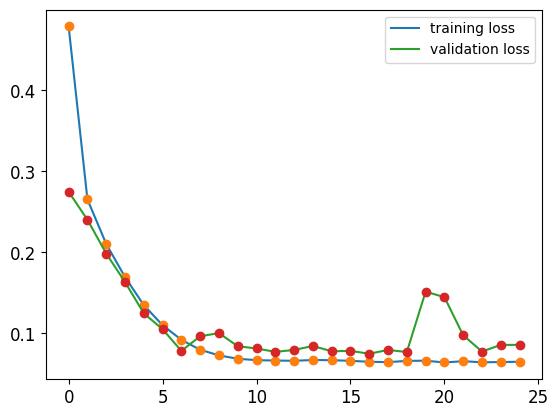

In [35]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

In [36]:
y_pred_tf_norm_bay_opt = clf.predict(X_test)

#Renormalize
y_pred_tf_bay_opt = qt.inverse_transform(y_pred_tf_norm_bay_opt.reshape(-1, 1))

3/3 [==============================] - 1s 98ms/step


In [37]:
# accuracy check
mse_tf_bay_opt = mean_squared_error(y_test_tf, y_pred_tf_bay_opt)
rmse_tf_bay_opt = mse_tf_bay_opt**(0.5) 

print(f'RMSE LightGBM no optimization: {rmse:.4f}')
print(f'RMSE LightGBM Random Search: {rmse_lgb_rand_opt:.4f}')
print(f'RMSE TensorFlow no optimization: {rmse_tf:.4f}')
print(f'RMSE TensorFlow Random Search: {rmse_tf_rand_opt:.4f}')
print(f'RMSE TensorFlow Bayesian Optimization: {rmse_tf_bay_opt:.4f}')

RMSE LightGBM no optimization: 5.2325
RMSE LightGBM Random Search: 5.1717
RMSE TensorFlow no optimization: 6.1513
RMSE TensorFlow Random Search: 6.1330
RMSE TensorFlow Bayesian Optimization: 6.6982
